In [1]:
import io
from collections import Counter

import numpy as np
import pandas as pd
from scipy import io
import sklearn.model_selection
import sklearn.tree
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin

import sys
!{sys.executable} -m pip install graphviz --user
import pydot

eps = 1e-5  # a small number

You are using pip version 18.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 3. Decision Trees for Classification

### 3.1 Implement Decision Trees

In [2]:
eps = 1e-5  # a small number

In [3]:
class DecisionTree:
    def __init__(self, max_depth=3, max_feature=None, feature_labels=None, rf=False):
        self.max_depth = max_depth
        self.max_feature = max_feature
        self.features = feature_labels
        self.rf = rf
        
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes

    @staticmethod
    def information_gain(X, y, thresh):
        # TODO implement information gain function
        previous = DecisionTree.entropy(y)
        y0 = y[np.where(X < thresh)[0]]
        y1 = y[np.where(X >= thresh)[0]]
        current = len(y0) / len(y) * DecisionTree.entropy(y0) + len(y1) / len(y) * DecisionTree.entropy(y1)
        return previous - current
    
    @staticmethod
    def purification(X, y, thresh): 
        previous = DecisionTree.gini_impurity(X, y, thresh)
        y0 = y[np.where(X < thresh)[0]]
        y1 = y[np.where(X >= thresh)[0]]
        current = len(y0) / len(y) * DecisionTree.gini_impurity(y0) + len(y1) / len(y) * DecisionTree.gini_impurity(y1)
        return previous - current
        
    @staticmethod
    def gini_impurity(y):
        # TODO implement gini_impurity function
        if len(y) == 0: 
            return 0
        unique, counts = np.unique(y, return_counts=True)
        percents = counts / len(y)
        return 1 - sum([p*p for p in percents])
    
    # IMPLEMENT ENTROPY
    @staticmethod
    def entropy(y): 
        if len(y) == 0: 
            return 0
        unique, counts = np.unique(y, return_counts=True)
        percents = counts / len(y)
        for p in percents: 
            if np.abs(p) <= eps: 
                return 0
        return -sum([p * np.log2(p) for p in percents])

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
#         print(X[:, idx].shape)
#         print(thresh)
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1
    
    def segmenter(self, X, y):
        # compute entropy gain for all single-dimension splits,
        # thresholding with a linear interpolation of 10 values
        gains = []
        # The following logic prevents thresholding on exactly the minimum
        # or maximum values, which may not lead to any meaningful node
        # splits.
        thresholds = np.array([
            np.linspace(
                np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
            for i in range(X.shape[1])
        ])
        for i in range(X.shape[1]):
            gains.append([
                self.information_gain(X[:, i], y, t) for t in thresholds[i, :]
            ])
        gains = np.nan_to_num(np.array(gains))
        split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
        return split_idx, thresholds[split_idx, thresh_idx]
        
    
    def segmenter_random_forest(self, X, y): 
        # take bootstrap sample of size n for the current node
        np.random.seed(189)
        bootstrap_indices = np.random.choice(X.shape[1], size=self.max_feature, replace=False)
        bootstrap_indices.sort()
        bootstrap_X = X[:, bootstrap_indices]
        bootstrap_y = y
        split_idx, threshold = self.segmenter(X[:, bootstrap_indices], y)
        return bootstrap_indices[split_idx], threshold
        
    def fit(self, X, y):
        if self.max_depth > 0:
            
            # SEGMENTER 1
#             # compute entropy gain for all single-dimension splits,
#             # thresholding with a linear interpolation of 10 values
#             gains = []
#             # The following logic prevents thresholding on exactly the minimum
#             # or maximum values, which may not lead to any meaningful node
#             # splits.
#             thresh = np.array([
#                 np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
#                 for i in range(X.shape[1])
#             ])
#             for i in range(X.shape[1]):
#                 gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])

#             gains = np.nan_to_num(np.array(gains))
#             self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
#             self.thresh = thresh[self.split_idx, thresh_idx]
            # SEGMENTER 1
            
            if self.rf: 
                self.split_idx, self.thresh = self.segmenter_random_forest(X, y)
            else: 
                self.split_idx, self.thresh = self.segmenter(X, y)
            
            X0, y0, X1, y1 = self.split(X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat
    
    def __repr__(self, depth=0): 
        if self.max_depth > 0: 
            node = '\t'*depth + 'Node at depth=' + str(depth) + '\n'
            node = node + '\t'*depth + 'Feature=' + str(self.features[self.split_idx]) + ' Thresh=' + str(self.thresh) + '\n'
            node = node + self.left.__repr__(depth+1)
            node = node + self.right.__repr__(depth+1)
        else: 
            node = '\t'*depth + 'leaf: ' + str(self.pred) + '\n'
        return node

### 3.2 Implement Random Forests

In [4]:
class BaggedTrees(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.decision_trees = [
            DecisionTree(max_depth=params['max_depth'], feature_labels=params['feature_labels'], rf=False)
            for i in range(self.n)
        ]

    def fit(self, X, y):
        # TODO implement function
        for i in range(self.n): 
            indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
            X_curr = X[indices, :]
            y_curr = y[indices]
            self.decision_trees[i].fit(X_curr, y_curr)
        return self
        
    def predict(self, X):
        # TODO implement function
        results = [self.decision_trees[i].predict(X) for i in np.arange(self.n)]
        return np.round(np.mean(results, axis=0))

In [5]:
class RandomForest(BaggedTrees):
    def __init__(self, params=None, n=200, m=1):
        if params is None:
            params = {}
        # TODO implement function
        self.params = params
        self.n = n
        self.max_feature = m
        self.decision_trees = [
            DecisionTree(max_depth=params['max_depth'], max_feature=m, 
                         feature_labels=params['feature_labels'], rf=True)
            for i in range(self.n)
        ]
        pass

In [6]:
# class BoostedRandomForest(RandomForest):
#     def fit(self, X, y):
#         self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
#         self.a = np.zeros(self.n)  # Weights on decision trees
#         # TODO implement function
        
#         return self

#     def predict(self, X):
#         # TODO implement function
#         pass

**3.2 Preprocessing**

In [7]:
def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == b''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == b'-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(np.float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=np.float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features


def evaluate(clf):
    print("Cross validation", sklearn.model_selection.cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]
        print("First splits", first_splits)


# if __name__ == "__main__":
#     dataset = "titanic"
#     params = {
#         "max_depth": 5,
#         # "random_state": 6,
#         "min_samples_leaf": 10,
#     }
#     N = 100

#     if dataset == "titanic":
#         # Load titanic data
#         path_train = 'datasets/titanic/titanic_training.csv'
#         data = genfromtxt(path_train, delimiter=',', dtype=None)
#         path_test = 'datasets/titanic/titanic_testing_data.csv'
#         test_data = genfromtxt(path_test, delimiter=',', dtype=None)
#         y = data[1:, 0]  # label = survived
#         class_names = ["Died", "Survived"]

#         labeled_idx = np.where(y != b'')[0]
#         y = np.array(y[labeled_idx], dtype=np.int)
#         print("\n\nPart (b): preprocessing the titanic dataset")
#         X, onehot_features = preprocess(data[1:, 1:], onehot_cols=[1, 5, 7, 8])
#         X = X[labeled_idx, :]
#         Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
#         assert X.shape[1] == Z.shape[1]
#         features = list(data[0, 1:]) + onehot_features

#     elif dataset == "spam":
#         features = [
#             "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
#             "height", "featured", "differ", "width", "other", "energy", "business", "message",
#             "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
#             "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
#             "ampersand"
#         ]
#         assert len(features) == 32

#         # Load spam data
#         path_train = 'datasets/spam_data/spam_data.mat'
#         data = scipy.io.loadmat(path_train)
#         X = data['training_data']
#         y = np.squeeze(data['training_labels'])
#         Z = data['test_data']
#         class_names = ["Ham", "Spam"]

#     else:
#         raise NotImplementedError("Dataset %s not handled" % dataset)

#     print("Features:", features)
#     print("Train/test size:", X.shape, Z.shape)

#     print("\n\nPart 0: constant classifier")
#     print("Accuracy", 1 - np.sum(y) / y.size)

#     # Basic decision tree
#     print("\n\nPart (a-b): simplified decision tree")
#     dt = DecisionTree(max_depth=3, feature_labels=features)
#     dt.fit(X, y)
#     print("Predictions", dt.predict(Z)[:100])

#     print("\n\nPart (c): sklearn's decision tree")
#     clf = sklearn.tree.DecisionTreeClassifier(random_state=189, **params)
#     clf.fit(X, y)
#     evaluate(clf)
#     out = io.StringIO()
#     sklearn.tree.export_graphviz(
#         clf, out_file=out, feature_names=features, class_names=class_names)
#     graph = pydot.graph_from_dot_data(out.getvalue())
#     pydot.graph_from_dot_data(out.getvalue())[0].write_pdf("%s-tree.pdf" % dataset)

#     # TODO implement and evaluate parts c-h


### 3.3 Describe Implementation Details

**1. How did you deal with categorical features and missing values?**

I fill the missing values with mode of that column. Categorical features are processed using one-hot encoding. If the frequency of one categorical value is less than 10, then this value is ignored. 

**2. What was your stopping criterion?**

The node will stop splitting if it has already reached the max depth given, or it is pure (i.e. contains only points from one of the classes). 

**3. How did you implement random forests?**

I implemented random forests by basing it on the BaggedTrees class. While bagged trees only take bootstrap sample of the sample points, random forest take a sample of features at each node. Therefore, I changed part of the fit method to realize the process of sampling features and splitting based on information gain on the sampled features. 

**4. Did you do anything special to speed up training?**

I tuned the hyperparameter to prevent overfitting and to speed up training (e.g. small tree depth). 

**5. Anything else cool you implemented?**

Sorry no...

### 3.4 Performance Evaluation

**Titanic Data**

In [9]:
titanic = genfromtxt('hw5_code/titanic_training.csv', delimiter=',', dtype=None)
t_testing = genfromtxt('hw5_code/titanic_testing_data.csv', delimiter=',', dtype=None)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


In [10]:
# original data columns
titanic[0,:]

array([b'survived', b'pclass', b'sex', b'age', b'sibsp', b'parch',
       b'ticket', b'fare', b'cabin', b'embarked'], dtype='|S18')

In [11]:
# PROCESS TRAINING DATA

col_names = titanic[0, 1:].tolist()
X = titanic[1:, 1:]
y = titanic[1:, 0]

# Drop the row if y has missing values
valid_y_indices = [ind for ind in np.arange(len(y)) if y[ind] != b'']
X = X[valid_y_indices, :]
y = y[valid_y_indices]
y = np.array([int(i) for i in y])

X_processed, one_hot_features = preprocess(X, onehot_cols=[1, 5, 7, 8])
col_names.extend(one_hot_features)

X_processed = pd.DataFrame(X_processed, columns=col_names)

# Drop the all zero columns (onehot_cols)
X_processed = X_processed.drop([col_names[i] for i in [1, 5, 7, 8]], axis=1)



# # PROCESS TESTING DATA


# X_testing = t_testing[1:, :]
# X_testing_processed, _ = preprocess(X_testing, onehot_cols=[1, 5, 7, 8])

In [12]:
# TRAINGING & VALIDATION SPLIT

def train_valid_split(X, y, train_num, percent=True): 
    if percent: 
        np.random.seed(189)
        train_indices = np.random.choice(np.arange(len(y)), round(len(y) * train_num), replace=False)
    else: 
        train_indices = np.random.choice(np.arange(len(y)), train_num, replace=False)
    valid_indices = []
    for i in np.arange(len(y)): 
        if i not in train_indices: 
            valid_indices.append(i)
    train_X = X[train_indices, :]
    train_y = y[train_indices]
    test_X = X[valid_indices, :]
    test_y = y[valid_indices]
    
    return train_X, train_y, test_X, test_y

def accuracy(y, y_hat): 
    score_r = 0
    for i in np.arange(len(y)): 
        if y[i] == y_hat[i]: 
            score_r += 1
    return score_r / len(y)

def results_to_csv(y_test):
    y_test = y_test.astype(int)
    df = pd.DataFrame({'Category': y_test})
    df.index += 1  # Ensures that the index starts at 1. 
    df.to_csv('submission.csv', index_label='Id')


In [13]:
# SPLIT TRAINING & VALIDATION

train_X, train_y, valid_X, valid_y = train_valid_split(X_processed.values, y, 0.75)

**Decision Tree**

In [14]:
titanic_dt = DecisionTree(max_depth=3, max_feature=None, feature_labels=None, rf=False)
titanic_dt.fit(train_X, train_y)
y_training_pred = titanic_dt.predict(train_X)
y_valid_pred = titanic_dt.predict(valid_X)

In [15]:
print('Titanic Decision Tree: Training accuracy')

accuracy(train_y, y_training_pred)

Titanic Decision Tree: Training accuracy


0.8010680907877169

In [16]:
print('Titanic Decision Tree: Validation accuracy')

accuracy(valid_y, y_valid_pred)

Titanic Decision Tree: Validation accuracy


0.8

**Random Forest**

In [17]:
titanic_rf = RandomForest(params={'max_depth': 5, 'rf': True, 'feature_labels': None}, n=200, m=5)
titanic_rf.fit(train_X, train_y)

# titanic_rf.fit(X_processed.values, np.array([int(i) for i in y]))

y_training_pred = titanic_rf.predict(train_X)
y_valid_pred = titanic_rf.predict(valid_X)

In [18]:
print('Titanic Random Forest: Training accuracy')

accuracy(train_y, y_training_pred)

Titanic Random Forest: Training accuracy


0.8170894526034713

In [19]:
print('Titanic Random Forest: Validation accuracy')

accuracy(valid_y, y_valid_pred)

Titanic Random Forest: Validation accuracy


0.82

**Spam Data**

In [19]:
data = io.loadmat("hw5_code/spam_data.mat")
fields = ["training_data", "training_labels", "test_data"]
for field in fields:
    print(field, data[field].shape)
X = data['training_data']
y = data['training_labels'][0]
s_testing = pd.DataFrame(data=data['test_data'])

training_data (5172, 32)
training_labels (1, 5172)
test_data (5857, 32)


In [20]:
def train_valid_split(X, y, train_num, percent=True): 
    if percent: 
        np.random.seed(189)
        train_indices = np.random.choice(np.arange(len(y)), round(len(y) * train_num), replace=False)
    else: 
        train_indices = np.random.choice(np.arange(len(y)), train_num, replace=False)
    valid_indices = []
    for i in np.arange(len(y)): 
        if i not in train_indices: 
            valid_indices.append(i)
    train_X = X[train_indices, :]
    train_y = y[train_indices]
    test_X = X[valid_indices, :]
    test_y = y[valid_indices]
    
    return train_X, train_y, test_X, test_y

In [21]:
train_X, train_y, valid_X, valid_y = train_valid_split(X, y, 0.75)

**Decision Tree**

In [199]:
spam_dt = DecisionTree(max_depth=10, max_feature=None, feature_labels=None, rf=False)
spam_dt.fit(train_X, train_y)
y_training_pred = spam_dt.predict(train_X)
y_valid_pred = spam_dt.predict(valid_X)

In [23]:
print('Spam Decision Tree: Training accuracy')

accuracy(train_y, y_training_pred)

Spam Decision Tree: Training accuracy


0.8378448053622067

In [24]:
print('Spam Decision Tree: Validation accuracy')

accuracy(valid_y, y_valid_pred)

Spam Decision Tree: Validation accuracy


0.822892498066512

**Random Forest**

In [39]:
spam_rf = RandomForest(params={'max_depth': 10, 'rf': True, 'feature_labels': None}, n=200, m=5)
spam_rf.fit(train_X, train_y)

y_training_pred = spam_rf.predict(train_X)
y_valid_pred = spam_rf.predict(valid_X)

In [26]:
print('Spam Random Forest: Training accuracy')

accuracy(train_y, y_training_pred)

Spam Random Forest: Training accuracy


0.8311420469193092

In [27]:
print('Spam Random Forest: Validation accuracy')

accuracy(valid_y, y_valid_pred)

Spam Random Forest: Validation accuracy


0.8128383604021655

In [28]:
spam_rf.max_feature

5

### 3.4 Performance Evaluation - Kaggle Submission

**Spam Data**

In [338]:
data = io.loadmat("hw5_code/spam_data.mat")
fields = ["training_data", "training_labels", "test_data"]
for field in fields:
    print(field, data[field].shape)
X = data['training_data']
y = data['training_labels'][0]
feature_names = data['column_names']

s_testing = data['test_data']

training_data (5172, 32)
training_labels (1, 5172)
test_data (5857, 32)


In [339]:
train_X, train_y, valid_X, valid_y = train_valid_split(X, y, 0.8)

In [340]:
# Tune max_depth

spam_rf_train_accuracy = []
spam_rf_valid_accuracy = []
max_depth = [5, 10, 15]

for mdepth in max_depth: 
    spam_rf = RandomForest(params={'max_depth': mdepth, 'rf': True, 'feature_labels': feature_names}, n=200, m=5)
    spam_rf.fit(train_X, train_y)

    spam_rf_train_accuracy.append(accuracy(train_y, spam_rf.predict(train_X)))
    spam_rf_valid_accuracy.append(accuracy(valid_y, spam_rf.predict(valid_X)))
    
    print(str(mdepth) + ' done')

5 done
10 done
15 done


In [341]:
spam_rf_train_accuracy

[0.8003866602223296, 0.8272112131464475, 0.8458192363460609]

In [342]:
spam_rf_valid_accuracy

[0.7998065764023211, 0.8017408123791102, 0.809477756286267]

Train with all data

In [346]:
train_X, train_y, valid_X, valid_y = train_valid_split(X, y, 1)

In [347]:
# Train with all training data & make prediction

spam_rf = RandomForest(params={'max_depth': 10, 'rf': True, 'feature_labels': feature_names}, n=200, m=10)
spam_rf.fit(train_X, train_y)

y_training_pred = spam_rf.predict(train_X)

In [348]:
y_testing_pred = spam_rf.predict(s_testing)

In [350]:
results_to_csv(y_testing_pred)

**Titanic**

In [325]:
titanic = genfromtxt('hw5_code/titanic_training.csv', delimiter=',', dtype=None)
t_testing = genfromtxt('hw5_code/titanic_testing_data.csv', delimiter=',', dtype=None)

# PROCESS TRAINING DATA

col_names = titanic[0, 1:].tolist()
X = titanic[1:, 1:]
y = titanic[1:, 0]

# Drop the row if y has missing values
valid_y_indices = [ind for ind in np.arange(len(y)) if y[ind] != b'']
X = X[valid_y_indices, :]
y = y[valid_y_indices]
y = np.array([int(i) for i in y])

X_processed, one_hot_features = preprocess(X, onehot_cols=[1, 5, 7, 8])
col_names.extend(one_hot_features)

X_processed = pd.DataFrame(X_processed, columns=col_names)

# Drop the all zero columns (onehot_cols)
X_processed = X_processed.drop([col_names[i] for i in [1, 5, 7, 8]], axis=1)

col_names_new = [col_names[i] for i in np.arange(len(col_names)) if i not in [1, 5, 7, 8]]

# PROCESS TESTING DATA

X_testing = t_testing[1:, :]
X_testing_processed, _ = preprocess(X_testing, onehot_cols=[1, 5, 7, 8])
X_testing_processed = pd.DataFrame(X_testing_processed, columns=col_names)
X_testing_processed = X_testing_processed[col_names_new]
X_testing_processed.shape

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


(310, 10)

In [326]:
train_X, train_y, valid_X, valid_y = train_valid_split(X_processed.values, y, 0.8)

In [327]:
# Tune max_depth

titanic_rf_train_accuracy = []
titanic_rf_valid_accuracy = []
max_depth = [3, 5, 8, 10]

for mdepth in max_depth: 
    titanic_rf = RandomForest(params={'max_depth': mdepth, 'rf': True, 'feature_labels': col_names_new}, n=200, m=5)
    titanic_rf.fit(train_X, train_y)

    titanic_rf_train_accuracy.append(accuracy(train_y, titanic_rf.predict(train_X)))
    titanic_rf_valid_accuracy.append(accuracy(valid_y, titanic_rf.predict(valid_X)))
    
    print(str(mdepth) + ' done')

3 done
5 done
8 done
10 done


In [328]:
titanic_rf_train_accuracy

[0.799749687108886, 0.8172715894868585, 0.8485607008760951, 0.8635794743429287]

In [329]:
titanic_rf_valid_accuracy

[0.805, 0.82, 0.81, 0.8]

In [332]:
train_X, train_y, valid_X, valid_y = train_valid_split(X_processed.values, y, 1)

In [333]:
# Train with all training data & make prediction



titanic_rf = RandomForest(params={'max_depth': 5, 'rf': True, 'feature_labels': col_names_new}, n=200, m=5)
titanic_rf.fit(train_X, train_y)

# titanic_rf.fit(X_processed.values, np.array([int(i) for i in y]))


RandomForest(m=None, n=200,
       params={'max_depth': 5, 'rf': True, 'feature_labels': [b'pclass', b'age', b'sibsp', b'parch', b'fare', b'male', b'female', b'S', b'C', b'Q']})

In [334]:
y_testing_pred = titanic_rf.predict(X_testing_processed.values)

In [335]:
results_to_csv(y_testing_pred)

### 3.5 Writeup Requirements for the Spam Dataset

In [20]:
data

NameError: name 'data' is not defined

In [ ]:
data = io.loadmat("hw5_code/spam_data.mat")
fields = ["training_data", "training_labels", "test_data"]
for field in fields:
    print(field, data[field].shape)
X = data['training_data']
y = data['training_labels'][0]
feature_names = data['column_names']
s_testing = pd.DataFrame(data=data['test_data'])

In [ ]:
train_X, train_y, valid_X, valid_y = train_valid_split(X, y, 0.8)

**Part 1: I didn't used any other features or feature transformations. **

**Part 2**

In [298]:
spam_dt = DecisionTree(max_depth=3, max_feature=None, feature_labels=feature_names, rf=False)
spam_dt.fit(train_X, train_y)

Node at depth=0
Feature=freq_exclamation_feature  Thresh=1e-05
	Node at depth=1
	Feature=freq_meter_feature        Thresh=1e-05
		Node at depth=2
		Feature=freq_para_feature         Thresh=1e-05
			leaf: 0
			leaf: 0
		leaf: 0
	Node at depth=1
	Feature=freq_and_feature          Thresh=1e-05
		Node at depth=2
		Feature=freq_meter_feature        Thresh=1e-05
			leaf: 1
			leaf: 0
		Node at depth=2
		Feature=freq_creative_feature     Thresh=1e-05
			leaf: 0
			leaf: 1

**Spam Data Point**

In [291]:
# Spam = 1
i1 = np.random.choice(np.arange(len(valid_y)))
while (valid_y[i1] != 1):
    i1 = np.random.choice(np.arange(len(valid_y)))

spam_point = valid_X[i1, :]
spam_point, i1
# i1

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]), 284)

In [300]:
feature_names

array(['freq_pain_feature        ', 'freq_private_feature     ',
       'freq_bank_feature        ', 'freq_money_feature       ',
       'freq_drug_feature        ', 'freq_spam_feature        ',
       'freq_prescription_feature', 'freq_creative_feature    ',
       'freq_height_feature      ', 'freq_featured_feature    ',
       'freq_differ_feature      ', 'freq_width_feature       ',
       'freq_other_feature       ', 'freq_energy_feature      ',
       'freq_business_feature    ', 'freq_message_feature     ',
       'freq_volumes_feature     ', 'freq_revision_feature    ',
       'freq_path_feature        ', 'freq_meter_feature       ',
       'freq_memo_feature        ', 'freq_planning_feature    ',
       'freq_pleased_feature     ', 'freq_record_feature      ',
       'freq_out_feature         ', 'freq_semicolon_feature   ',
       'freq_dollar_feature      ', 'freq_sharp_feature       ',
       'freq_exclamation_feature ', 'freq_para_feature        ',
       'freq_bracket_feat

In [292]:
spam_dt.predict(np.array([spam_point]))

array([1.])

At index = 284 of the validation data set: 

    Level 0: exclamation = 1 > 1e-05 => right child

    Level 1: and = 0 < 1e-05 => left child

    Level 2: meter = 0 < 1e-05 => left

    Level 3: result_leaf = 1

**Ham Data Point**

In [293]:
# Ham = 1

i2 = np.random.choice(np.arange(len(valid_y)))
while (y[i2] != 0): 
    i2 = np.random.choice(np.arange(len(y)))

ham_point = X[i2, :]
ham_point, i2
# i2

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 4057)

In [294]:
spam_dt.predict(np.array([ham_point]))

array([0.])

In [304]:
spam_dt.predict(np.array([ham_point]))

array([0.])

At index = 4057 of the validation data set:

    Level 0: exclamation = 0 < 1e-05 => left child

    Level 1: and = 0 < 1e-05 => left child

    Level 2: para = 0 < 1e-05 => left child

    Level 3: result_leaf = 0

**Part 3**

In [21]:
training_accuracy_spam = []
validation_accuracy_spam = []
max_depth = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40]

for mdepth in max_depth: 
    spam_dt = DecisionTree(max_depth=mdepth, max_feature=None, feature_labels=None, rf=False)
    spam_dt.fit(train_X, train_y)
    
    y_training_pred = spam_dt.predict(train_X)
    y_valid_pred = spam_dt.predict(valid_X)
    
    training_accuracy_spam.append(accuracy(train_y, y_training_pred))
    validation_accuracy_spam.append(accuracy(valid_y, y_valid_pred))
    
    print('Max depth = ' + str(mdepth) + ' done')

Max depth = 1 done
Max depth = 3 done
Max depth = 5 done
Max depth = 10 done
Max depth = 15 done
Max depth = 20 done
Max depth = 25 done
Max depth = 30 done
Max depth = 35 done
Max depth = 40 done


In [22]:
training_accuracy_spam

[0.7903871829105474,
 0.8010680907877169,
 0.8184245660881175,
 0.8945260347129506,
 0.9546061415220294,
 0.9786381842456608,
 0.9799732977303071,
 0.9799732977303071,
 0.9799732977303071,
 0.9799732977303071]

In [23]:
validation_accuracy_spam

[0.784, 0.8, 0.8, 0.788, 0.752, 0.74, 0.732, 0.732, 0.732, 0.732]

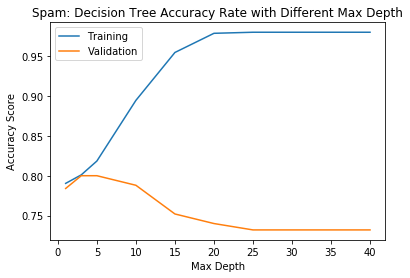

In [25]:
import matplotlib.pyplot as plt

plt.plot(max_depth, training_accuracy_spam, label='Training');
plt.plot(max_depth, validation_accuracy_spam, label='Validation');
plt.title('Spam: Decision Tree Accuracy Rate with Different Max Depth')
plt.xlabel('Max Depth');
plt.ylabel('Accuracy Score');
plt.legend();

Max depth of 3 and 5 have the same max validation accuracy rate of 0.8. The validation accuracy plot increases at first, and then start to fluctuate and decrease as max_depth further increases. It increases at first because larger depth allows more representation/explanation power of the model. However, as max_depth becomes even greater, the model is overfitting. Thus, validation accuracy decreases. 

### 3.6 Writeup Requirements for the Titanic Dataset

In [101]:
titanic = genfromtxt('hw5_code/titanic_training.csv', delimiter=',', dtype=None)
t_testing = genfromtxt('hw5_code/titanic_testing_data.csv', delimiter=',', dtype=None)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


In [102]:
# PROCESS TRAINING DATA

col_names = titanic[0, 1:].tolist()
X = titanic[1:, 1:]
y = titanic[1:, 0]

# Drop the row if y has missing values
valid_y_indices = [ind for ind in np.arange(len(y)) if y[ind] != b'']
X = X[valid_y_indices, :]
y = y[valid_y_indices]
y = np.array([int(i) for i in y])

X_processed, one_hot_features = preprocess(X, onehot_cols=[1, 5, 7, 8])
col_names.extend(one_hot_features)

X_processed = pd.DataFrame(X_processed, columns=col_names)

# Drop the all zero columns (onehot_cols)
X_processed = X_processed.drop([col_names[i] for i in [1, 5, 7, 8]], axis=1)

col_names = [col_names[i] for i in np.arange(len(col_names)) if i not in [1, 5, 7, 8]]


# # PROCESS TESTING DATA

# X_testing = t_testing[1:, :]
# X_testing_processed, _ = preprocess(X_testing, onehot_cols=[1, 5, 7, 8])

In [103]:
# SPLIT TRAINING & VALIDATION

train_X, train_y, valid_X, valid_y = train_valid_split(X_processed.values, y, 0.75)

In [113]:
titanic_dt = DecisionTree(max_depth=3, max_feature=None, feature_labels=col_names, rf=False)
titanic_dt.fit(train_X, train_y)

Node at depth=0
Feature=b'male' Thresh=1e-05
	Node at depth=1
	Feature=b'pclass' Thresh=2.11111
		Node at depth=2
		Feature=b'S' Thresh=1e-05
			leaf: 1
			leaf: 1
		Node at depth=2
		Feature=b'fare' Thresh=27.816669999999995
			leaf: 1
			leaf: 0
	Node at depth=1
	Feature=b'pclass' Thresh=1.00001
		Node at depth=2
		Feature=b'age' Thresh=52.99999666666666
			leaf: 0
			leaf: 0
		Node at depth=2
		Feature=b'age' Thresh=48.99999666666667
			leaf: 0
			leaf: 0

**Tune hyperparameter for titanic-random forest**

In [54]:
training_accuracy_titanic = []
validation_accuracy_titanic = []
max_depth = [1, 3, 5, 8, 10]

for mdepth in max_depth: 
    titanic_dt = DecisionTree(max_depth=mdepth, max_feature=None, feature_labels=None, rf=False)
    titanic_dt.fit(train_X, train_y)
    
    y_training_pred = titanic_dt.predict(train_X)
    y_valid_pred = titanic_dt.predict(valid_X)
    
    training_accuracy_titanic.append(accuracy(train_y, y_training_pred))
    validation_accuracy_titanic.append(accuracy(valid_y, y_valid_pred))
    
    print('Max depth = ' + str(mdepth) + ' done')

Max depth = 1 done
Max depth = 3 done
Max depth = 5 done
Max depth = 8 done
Max depth = 10 done


In [55]:
training_accuracy_titanic

[0.7903871829105474,
 0.8010680907877169,
 0.8184245660881175,
 0.8678237650200267,
 0.8945260347129506]

In [56]:
validation_accuracy_titanic

[0.784, 0.8, 0.8, 0.804, 0.788]